In [1]:
import h5py, pathlib
from silx.io.dictdump import h5todict, dicttoh5
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pathlib

plt.style.use("bmh")

In [2]:
%matplotlib inline
# %matplotlib widget

In [3]:
# run_dir = pathlib.Path("/home/AG_Salditt/Messzeiten/2024/extern/SIRIUS_MOGNO/data/20233864")
# data_dir = run_dir / "data/KBfocus_Char_RHD_Experiment"

data_dir = pathlib.Path("frames")

In [4]:
def read_scan(i_scan, read_frames=False):
    h5_fname = data_dir / f"KBfocus_Char_RHD_scan_{i_scan:04d}.hdf5"
    if read_frames:
        with h5py.File(h5_fname) as f:
            # f.visititems(print)
            frames = np.array(f["entry/beamline/detector/pco_frames"])
    else:
        frames = None
    
    motion = h5todict(str(h5_fname), "entry/beamline/motion", asarray=False)
    return frames, motion

frames0, motion0 = read_scan(3, read_frames=True)
fshape = frames0.shape[1:]

In [7]:
scan_ids = range(3, 495)
load_frames = False  # much faster, when not reading the frames (only motor positions)


if load_frames:
    frames = np.empty((len(scan_ids), len(frames0), *fshape), dtype=frames0.dtype)

positions = {key:[] for key in motion0}
wgx_pos = np.empty((len(scan_ids), len(frames0)))
wgy_pos = np.empty((len(scan_ids), len(frames0)))
wgz_pos = np.empty((len(scan_ids), len(frames0)))

for i, i_scan in enumerate(tqdm(scan_ids)):
    if load_frames:
        frames[i], motion = read_scan(i_scan, read_frames=True)
    else:
        _, motion = read_scan(i_scan)
    
    [positions[key].append(motion[key].mean()) for key in motion]
    wgx_pos[i] = motion["wgx"]
    wgy_pos[i] = motion["wgy"]
    wgz_pos[i] = motion["wgz"]

wgx_pos = wgx_pos.reshape(12, 41, -1)
wgy_pos = wgy_pos.reshape(12, 41, -1)
wgz_pos = wgz_pos.reshape(12, 41, -1)

for key, p in positions.items():
    positions[key] = np.array(p)

  0%|          | 0/492 [00:00<?, ?it/s]

## motor positions

  - wgz: position in direction of the x-ray beam (in mm), the focus being "somewhat close to zero"
  - wgx: horizontal position (in mm)
  - wgy: vertical position (in mm)

The scan consists of:
  - 12 wgz positions x 41 wgy positions x 40 wgx positions

Detector (PCO) positioned 1m from the focus.

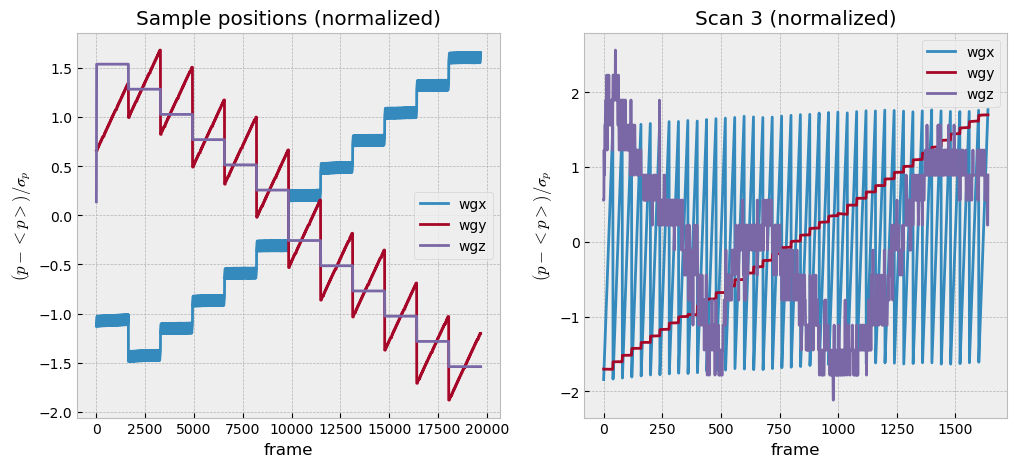

In [8]:
i_scan = 3
plt.figure(figsize=(12, 5))
labels = ("wgx", "wgy", "wgz")
for i, p in enumerate((wgx_pos, wgy_pos, wgz_pos)):
    plt.subplot(121)
    plt.plot(((p-p.mean()) / p.std()).ravel(), label=labels[i]);
    plt.legend()
    plt.ylabel("$(p - <p> ) / σ_p$")
    plt.xlabel("frame")
    plt.title("Sample positions (normalized)")
    
    plt.subplot(122)
    plt.plot(((p[i_scan]-p[i_scan].mean()) / p[i_scan].std()).ravel(), label=labels[i]);
    plt.ylabel("$(p - <p> ) / σ_p$")
    plt.xlabel("frame")
    plt.title(f"Scan {i_scan} (normalized)")
    plt.legend()


## vizualize frames 
(have to be loaded first)

In [19]:
import napari
v = napari.view_image(frames)

In [18]:
empty = frames.mean((0, 1)).astype(np.float32)
projs = frames / empty

/tmp/ipykernel_582207/1138877819.py:2: RuntimeWarning: invalid value encountered in divide
  projs = frames / empty


In [20]:
v = napari.view_image(projs)